In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [2]:
# for TPU
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0  10816      0 --:--:-- --:--:-- --:--:-- 10816
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200515 ...
Found existing installation: torch 1.7.0
Uninstalling torch-1.7.0:
Done updating TPU runtime
  Successfully uninstalled torch-1.7.0
Found existing installation: torchvision 0.8.1
Uninstalling torchvision-0.8.1:
  Successfully uninstalled torchvision-0.8.1
Copying gs://tpu-pytorch/wheels/torch-nightly+20200515-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/91.0 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200515-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/119.5 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly+20200515-cp37-cp37m-l

In [3]:
# for TPU
import torch_xla
import torch_xla.core.xla_model as xm

import transformers
from transformers import (BertConfig, BertForSequenceClassification, BertTokenizer, 
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer, 
                                  XLMRobertaConfig, XLMRobertaTokenizer, XLMRobertaForSequenceClassification)            
from transformers import AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm, trange

from sklearn.metrics import classification_report, f1_score, accuracy_score

In [4]:
os.environ["WANDB_API_KEY"] = "0" #to silence warning

In [5]:
#for reproducibility
np.random.seed(0)
torch.manual_seed(5) 

In [6]:
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")

train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [7]:
PRETRAINED_MODEL_TYPES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer, 'bert-base-multilingual-cased'),
    'xlnet': (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer, 'xlnet-base-cased'),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer, 'xlm-mlm-xnli15-1024'),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer, 'roberta-base'),
    'xlmroberta': (XLMRobertaConfig, XLMRobertaForSequenceClassification, XLMRobertaTokenizer, 'xlm-roberta-large')
}

config_class, model_class, tokenizer_class, model_name = PRETRAINED_MODEL_TYPES['xlmroberta']

In [8]:
# # Automatically retrieve the relevant model given the name/path to the pretrained weights/config/vocabulary.

# tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

# tokenizer

In [9]:
# configuration = config_class.from_pretrained(model_name)

tokenizer = tokenizer_class.from_pretrained(model_name) 

tokenizer

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='xlm-roberta-large', vocab_size=250002, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})

In [10]:
tokenizer.vocab_size

250002

In [11]:
tokenizer.special_tokens_map

{'bos_token': '<s>',
 'eos_token': '</s>',
 'unk_token': '<unk>',
 'sep_token': '</s>',
 'pad_token': '<pad>',
 'cls_token': '<s>',
 'mask_token': '<mask>'}

In [12]:
# Configuration Settings

EPOCHS = 3 # Number of training epochs (authors recommend between 2 and 4)
BATCH_SIZE = 64
# BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 100
PATIENCE = 0
NUM_LABELS = 3
FREEZE_LAYERS = False
LEARNING_RATE = 1e-5

In [13]:
from sklearn.model_selection import train_test_split
# Stratify ensures that each set contains approximately the same percentage of samples of each target class as the original set.
train, validation = train_test_split(train, stratify=train.label.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [14]:
# check the number of rows and columns in the training set
print("Train data: {} \n".format(train.shape))

print("Validation data: {} \n".format(validation.shape))

Train data: (9696, 6) 

Validation data: (2424, 6) 



In [15]:
def encode(df, tokenizer, max_len=50, testing=False):
    
    pairs = df[['premise','hypothesis']].values.tolist() #shape=[num_examples]
    
    print ("Encoding...")
    encoded_dict = tokenizer.batch_encode_plus(pairs, max_length=max_len, padding=True, truncation=True,
                                               add_special_tokens=True, return_attention_mask=True, return_tensors='pt')
    print ("Complete")
    
    if not testing:
        target_labels = torch.tensor(df.label.values)
    else:
        target_labels = None
       
    inputs = {
        'input_word_ids': encoded_dict['input_ids'],
        'input_mask': encoded_dict['attention_mask'],
        'input_targets': target_labels}
    
    return inputs 

In [16]:
train_input = encode(train, tokenizer=tokenizer, max_len=MAX_LEN)

Encoding...
Complete


In [17]:
train_input['input_word_ids'].shape #[9696, 50]
train_input['input_mask'].shape #[9696, 50]
# train_input['input_targets'].shape #[9696]

torch.Size([9696, 100])

In [18]:
print (train_input['input_word_ids'][0])
print (train_input['input_mask'][0])
print (train_input['input_targets'][0])

tensor([     0,    382,    927,  13656,    876,      5,    238,      5,  91127,
          5447,  46512,  20650,  63457,  20102,    136,   3789, 127067,   9022,
         10776,      7,      2,      2,  63457,  20102,    136,   3789, 127067,
          9022,  10776,      7,   3542,  46512,  29367,     23,     70,    382,
           927, 142642,    876,      5,    238,      5,      2,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 

In [19]:
validation_input = encode(validation, tokenizer=tokenizer, max_len=MAX_LEN)

Encoding...
Complete


In [20]:
validation_input['input_word_ids'].shape #[2424, 50]
validation_input['input_mask'].shape #[2424, 50]
# validation_input['input_targets'].shape #[2424]

torch.Size([2424, 100])

In [21]:
print (validation_input['input_word_ids'][0])
print (validation_input['input_mask'][0])
print (validation_input['input_targets'][0])

tensor([     0,  69107,  83617, 115100, 151836,  10343,  24541,  21352,   3380,
         35266,  37541,   1834, 132840,  22187, 173357,  55854,  96308,  83979,
          2469, 204092, 180345,   9581,  15318, 151836,  10343,  29332,  18538,
         11806, 236007,   2623,   4260, 235616,   6715,  79228,   1213,  68839,
        219569,   1213, 106096,   1037,  76334, 115100, 155078,      2,      2,
             6, 115100,   1037,  83758,  19854,   2386, 173357,  55854,    699,
        195493,      2,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 

In [22]:
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_input['input_word_ids'], train_input['input_mask'], train_input['input_targets'])
train_sampler = RandomSampler(train_data) #Samples elements randomly. If without replacement, then sample from a shuffled dataset. If with replacement, then user can specify num_samples to draw.
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_input['input_word_ids'], validation_input['input_mask'], validation_input['input_targets'])
validation_sampler = SequentialSampler(validation_data) #Samples elements sequentially, always in the same order.
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

In [23]:
# Load model, the pretrained model will include a single linear classification layer on top for classification. 
model = model_class.from_pretrained(model_name, num_labels=NUM_LABELS, output_attentions=False, output_hidden_states=False)
# model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name, labels=NUM_LABELS, output_attentions=False, output_hidden_states=False) #load pretrained model weights

# for TPU
device = xm.xla_device()
model.to(device)

Downloading:   0%|          | 0.00/513 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.den

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
     

In [24]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total number of trainable parameters with 24 transformer layers: {}'.format(params))

Total number of trainable parameters with 24 transformer layers: 559893507


In [25]:
# count = 0
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         count += 1
# count #all the parameter names are trainable

In [26]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print (name, param.data.shape)

In [27]:
# # Get all of the model's parameter names as a list of tuples.
# params = list(model.named_parameters())

# print('The BERT model has {:} different named parameters.\n'.format(len(params)))

# print('==== Embedding Layer ====\n')

# for p in params[0:5]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# print('\n==== First Layer ====\n')

# for p in params[5:21]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# print('\n==== Output Layer ====\n')

# for p in params[-4:]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [28]:
if FREEZE_LAYERS:
    # Fine-tune from this layer onwards
    # Embedding_Layer has 5 named_parameters, each Transformer layer has 16 named_parameters, 
    # and there are total of 24 layers of which we'll freeze the first 12.
    # Hence fine_tune_at = 5 + (12 * 16) = 197
    embed_layers = 1
    embed_parameters = 5
    transformer_layers_to_freeze = 12 #freeze the first n layers
    named_parameters_per_layer = 16
    fine_tune_at = (embed_layers * embed_parameters) + (transformer_layers_to_freeze * named_parameters_per_layer)

    # Get the first 197 of the model's parameter names as a list of tuples
    params_to_freeze = list(model.named_parameters())[:fine_tune_at]

    # Freeze all the layers before the `fine_tune_at` layer
    for name, param in params_to_freeze:
        print (name, param.data.shape)
        param.requires_grad = False


    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print('Total number of trainable parameters after freezing bottom {} transformer layers and {} embed layer: {}'.format(transformer_layers_to_freeze, embed_layers, params))
else:
    print('Model will be fine-tuned by re-training all the layers')

Model will be fine-tuned by re-training all the layers


In [29]:
# #setting custom optimization parameters. You may implement a scheduler here as well.
# param_optimizer = list(model.named_parameters())
# no_decay = ['bias', 'gamma', 'beta']
# optimizer_grouped_parameters = [
#     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
#      'weight_decay_rate': 0.01},
#     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
#      'weight_decay_rate': 0.0}
# ]
# optimizer = AdamW(optimizer_grouped_parameters,lr=LEARNING_RATE,correct_bias=True)

# warmup_steps = int(EPOCHS * train.shape[0] * 0.1 / BATCH_SIZE)
optimizer = AdamW(model.parameters(),lr=LEARNING_RATE)  # Default optimization
# Learning rate scheduling is applied after optimizer’s update to adjust the learning rate based on the number of epochs.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_dataloader) * EPOCHS) #number of batches * number of epochs

In [30]:
train_losses, train_accuracies = [], [] # Store loss and accuracy for plotting
validation_losses, validation_accuracies = [], [] # Store loss and accuracy for plotting
best_accuracy = 0.0

for i in trange(EPOCHS, desc="Epoch"):

  # Training
  model.train()

  predictions, truth_labels = [], []
  train_loss = 0
  
  for step, batch in enumerate(train_dataloader):
    batch = tuple(item.to(device) for item in batch)
    batch_input_ids, batch_input_mask, batch_labels = batch
    
    optimizer.zero_grad()

    # logits shape: [batch_size, num_classes]
    output = model(batch_input_ids, attention_mask=batch_input_mask, labels=batch_labels)
    loss = output.loss
    logits = output.logits
#     loss_func = CrossEntropyLoss() 
#     loss = loss_func(logits.view(-1,NUM_LABELS), batch_labels)  
    loss.backward() #back propagate the loss and compute the gradients
#     optimizer.step()
    # for TPU
    xm.optimizer_step(optimizer, barrier=True) #update the weights 
    scheduler.step()
    
    train_loss += loss.item()
    
    batch_logits = logits.detach().cpu().numpy() #shape: [batch_size, num_classes]
    batch_labels = batch_labels.to('cpu').tolist() #shape: [batch_size]
        
    batch_predictions = np.argmax(batch_logits, axis=1).tolist() #shape: [batch_size]
      
    predictions.extend(batch_predictions)
    truth_labels.extend(batch_labels)
    
    if step!=0 and step%38 == 0:
        print ('Training Batch {} of {}: current_avg_loss={}'.format(step, len(train_dataloader), round(train_loss/step+1, 2)))
        # print ('Training Batch {} of {}: current_avg_loss={}, lr={}'.format(step, len(train_dataloader), round(train_loss/step+1, 2), round(optimizer.param_groups[0]['lr'], 2)))       
  
  avg_train_acc = round(accuracy_score(y_true=truth_labels, y_pred=predictions), 2)*100   
  avg_train_loss = round(float(train_loss/len(train_dataloader)), 2)

  train_losses.append(avg_train_loss)
  train_accuracies.append(avg_train_acc)
    
  print("\nAverage Training Loss: {}".format(avg_train_loss))
  print("Average Train Accuracy: {}".format(avg_train_acc))

    

  # Validation
  predictions, truth_labels = [], []
  val_loss = 0

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  for step, batch in enumerate(validation_dataloader):
    batch = tuple(item.to(device) for item in batch)
    batch_input_ids, batch_input_mask, batch_labels = batch
    with torch.no_grad():
      output = model(batch_input_ids, attention_mask=batch_input_mask, labels=batch_labels)
      loss = output.loss
      logits = output.logits
      val_loss += loss.item()
#       loss_func = CrossEntropyLoss() 
#       loss = loss_func(logits.view(-1,NUM_LABELS), batch_labels)  

      batch_logits = logits.detach().cpu().numpy() #shape: [batch_size, num_classes]
      batch_labels = batch_labels.to('cpu').tolist() #shape: [batch_size]
        
      batch_predictions = np.argmax(batch_logits, axis=1).tolist() #shape: [batch_size]
      
      predictions.extend(batch_predictions)
      truth_labels.extend(batch_labels)
        
  
  avg_val_acc = round(accuracy_score(y_true=truth_labels, y_pred=predictions), 2)*100
  avg_val_loss = round(float(val_loss/len(validation_dataloader)), 2)
    
  if avg_val_acc > best_accuracy: 
    print ("Found best model at epoch {}".format(i))
    best_accuracy = avg_val_acc
    torch.save(model, 'best-model.pt')
#     torch.save(model.state_dict(), 'best-model-parameters.pt')
    
  validation_losses.append(avg_val_loss)
  validation_accuracies.append(avg_val_acc)
  
  print("\nAverage Validation Loss: {}".format(avg_val_loss))
  print("Average Validation Accuracy: {}".format(avg_val_acc))
  
  print("#################################")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 38 of 152: current_avg_loss=2.13
Training Batch 76 of 152: current_avg_loss=2.12
Training Batch 114 of 152: current_avg_loss=2.11

Average Training Loss: 1.1
Average Train Accuracy: 35.0
Found best model at epoch 0


Epoch:  33%|███▎      | 1/3 [07:18<14:37, 438.82s/it]


Average Validation Loss: 1.08
Average Validation Accuracy: 50.0
#################################
Training Batch 38 of 152: current_avg_loss=2.04
Training Batch 76 of 152: current_avg_loss=1.94
Training Batch 114 of 152: current_avg_loss=1.86

Average Training Loss: 0.8
Average Train Accuracy: 64.0
Found best model at epoch 1


Epoch:  67%|██████▋   | 2/3 [10:46<05:02, 302.69s/it]


Average Validation Loss: 0.59
Average Validation Accuracy: 77.0
#################################
Training Batch 38 of 152: current_avg_loss=1.59
Training Batch 76 of 152: current_avg_loss=1.56
Training Batch 114 of 152: current_avg_loss=1.55

Average Training Loss: 0.54
Average Train Accuracy: 79.0
Found best model at epoch 2


Epoch: 100%|██████████| 3/3 [14:13<00:00, 284.57s/it]


Average Validation Loss: 0.52
Average Validation Accuracy: 80.0
#################################


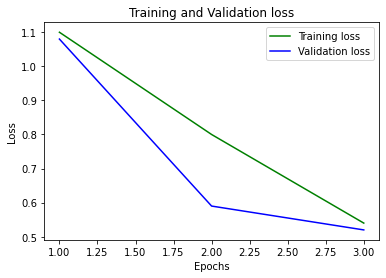

In [31]:
#plot training and validation losses over all epochs
epochs = range(1,EPOCHS+1)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, validation_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

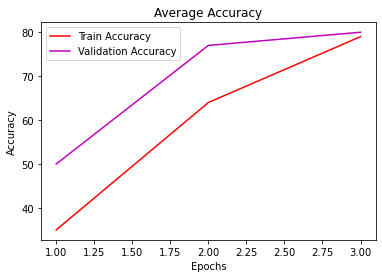

In [32]:
#plot validation accuracies over all epochs
epochs = range(1,EPOCHS+1)
plt.plot(epochs, train_accuracies, 'r', label='Train Accuracy')
plt.plot(epochs, validation_accuracies, 'm', label='Validation Accuracy')
plt.title('Average Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [34]:
test_input = encode(test, tokenizer, max_len=MAX_LEN, testing=True)

Encoding...
Complete


In [35]:
test_data = TensorDataset(test_input['input_word_ids'], test_input['input_mask'])
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [36]:
# Test

#load the best training model
print("Loading the best trained model")
model = torch.load('best-model.pt')

model.eval()

predictions = []

for step, batch in enumerate(test_dataloader):
    batch = tuple(item.to(device) for item in batch)
    batch_input_ids, batch_input_mask = batch
    with torch.no_grad():
      output = model(batch_input_ids, attention_mask=batch_input_mask)
      logits = output.logits #output[0] #[batch_size, num_classes]
      batch_logits = logits.detach().cpu().numpy() #shape: [batch_size, num_classes]        
      batch_predictions = np.argmax(batch_logits, axis=1).tolist() #shape: [batch_size]
      predictions.extend(batch_predictions)

Loading the best trained model


In [37]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions

submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,0


In [38]:
submission.to_csv("submission.csv", index = False)